# Goodreads Books Reviews


#### Imports

In [3]:
!pip install transformers datasets

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 325 kB 45.5 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
     |████████████████████████████████| 6.6 MB 20.8 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
     |████████████████████████████████| 212 kB 51.3 MB/s 
     |████████████████████████████████| 136 kB 47.5 MB/s 
     |████████████████████████████████| 1.1 MB 35.6 MB/s 
     |████████████████████████████████| 127 kB 50.8 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 
     |████████████████████████████████| 271 kB 55.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [4]:
# Import necessary libraries

from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu' # Setting up the device for GPU usage

#### Load Data

In [5]:
# Allow access to Google Drive files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Unzipping data files

!unzip gdrive/My\ Drive/Colab\ Notebooks/goodreads_books_reviews/data/goodreads_books_reviews.zip

Archive:  gdrive/My Drive/Colab Notebooks/goodreads_books_reviews/data/goodreads_books_reviews.zip
  inflating: goodreads_sample_submission.csv  
  inflating: goodreads_test.csv      
  inflating: goodreads_train.csv     


In [7]:
# Loading csv using load_dataset instead of pandas for speed

goodreads_train = load_dataset('csv', data_files='goodreads_train.csv')['train']
goodreads_test = load_dataset('csv', data_files='goodreads_test.csv')['train']

Using custom data configuration default-865a18ef15c9438e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-865a18ef15c9438e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-1ab66eb72bc343ae


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1ab66eb72bc343ae/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

#### Exploratory Data Analysis

In [8]:
# Converting to pandas dataframe for easier analysis

goodreads_train_df = goodreads_train.to_pandas()
goodreads_test_df = goodreads_test.to_pandas()

In [9]:
goodreads_train_df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,None,None,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,None,None,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [10]:
goodreads_test_df.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


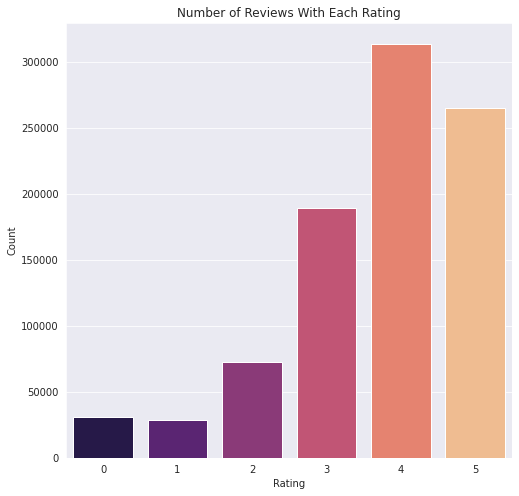

0     30988
1     28718
2     72627
3    188972
4    313688
5    265007
Name: rating, dtype: int64


In [11]:
# Class distribution of training set

def plot_dist(df):
    plt.figure(figsize=(8, 8))
    sns.barplot(x=df['rating'].value_counts().index, y=df['rating'].value_counts(), data=df, palette='magma')
    plt.title('Number of Reviews With Each Rating')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()
    print(df['rating'].value_counts().sort_index())

plot_dist(goodreads_train_df)

In [12]:
# Length of reviews

# word_count = goodreads_train_df['review_text'].str.split().apply(len)
# plt.figure(figsize=(20, 10))
# sns.boxplot(x=word_count, y='rating', data=goodreads_train_df, palette='magma')
# plt.title('Word Count of Real and Fraudulent Job Postings')
# plt.show()

#### Preprocessing

In [13]:
# Dropping columns except for text and label

dropped_columns = ['user_id', 'book_id', 'review_id', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
goodreads_train_df.drop(columns=dropped_columns, inplace=True)
goodreads_test_df.drop(columns=dropped_columns, inplace=True)

In [14]:
goodreads_train_df.head()

,rating,review_text
0,5,This is a special book. It started slow for ab...
1,3,Recommended by Don Katz. Avail for free in Dec...
2,3,"A fun, fast paced science fiction thriller. I ..."
3,0,Recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot..."


In [15]:
goodreads_test_df.head()

,review_text
0,** spoiler alert ** \n This is definitely one ...
1,"** spoiler alert ** \n ""You are what you drink..."
2,Roar is one of my favorite characters in Under...
3,** spoiler alert ** \n If you feel like travel...
4,3.5 stars \n I read and enjoyed the first two ...


In [16]:
# Fixing class imbalance in training set by under sampling from majority classes
# Data augmentation usually preferred to preserve information from majority classes but dataset needs to be reduced due to computational limitations

def undersample_dataset(df):

    X = df['review_text'].values.reshape(-1, 1)
    y = df['rating'].values

    # Capping majority classes at 35000 samples
    sampling_strategy = {
        2: 35000,
        3: 35000,
        4: 35000,
        5: 35000
    }

    rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_us, y_us = rus.fit_resample(X, y)
    df_us = pd.DataFrame({'review_text': X_us.reshape(-1), 'rating': y_us})
    return df_us

goodreads_train_df_us = undersample_dataset(goodreads_train_df)

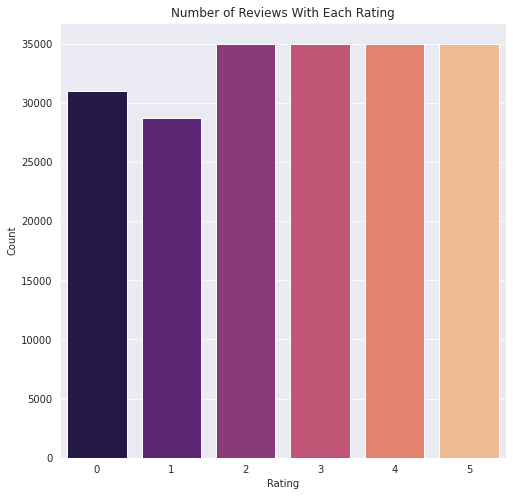

0    30988
1    28718
2    35000
3    35000
4    35000
5    35000
Name: rating, dtype: int64


In [17]:
plot_dist(goodreads_train_df_us)

In [18]:
# Renaming columns to names expected by model later

goodreads_train_df_us.rename(columns={'review_text': 'text', 'rating': 'label'}, inplace=True)
goodreads_test_df.rename(columns={'review_text': 'text'}, inplace=True)

In [19]:
# Converting back to Dataset format

goodreads_train = Dataset.from_pandas(goodreads_train_df_us)
goodreads_test = Dataset.from_pandas(goodreads_test_df)

In [20]:
goodreads_train

Dataset({
    features: ['text', 'label'],
    num_rows: 199706
})

In [21]:
goodreads_test

Dataset({
    features: ['text'],
    num_rows: 478033
})

In [22]:
# Splitting training data into a training and validation set as test dataset provided is not labelled

goodreads_train_split = goodreads_train.train_test_split(test_size=0.2)

In [23]:
goodreads_train_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 159764
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 39942
    })
})

In [24]:
# Reducing dataset size further for now due to computational limitations

def reduce_dataset(dataset):
    total_rows = dataset.num_rows
    sample_size = int(total_rows * 0.1) # Using 10% of data
    sample_indices = np.random.RandomState(42).randint(total_rows, size=sample_size)
    return dataset.select(sample_indices)

train_data = reduce_dataset(goodreads_train_split['train'])
test_data = reduce_dataset(goodreads_train_split['test'])

In [25]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 15976
})

In [26]:
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 3994
})

In [27]:
# Labels need to be encoded to ClassLabel type for custom datasets

train_data = train_data.class_encode_column('label')

Stringifying the column:   0%|          | 0/16 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/16 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

In [28]:
train_data.features

{'label': ClassLabel(num_classes=6, names=['0', '1', '2', '3', '4', '5'], id=None),
 'text': Value(dtype='string', id=None)}

In [29]:
test_data = test_data.class_encode_column('label')

Stringifying the column:   0%|          | 0/4 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/4 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
test_data.features

{'label': ClassLabel(num_classes=6, names=['0', '1', '2', '3', '4', '5'], id=None),
 'text': Value(dtype='string', id=None)}

In [31]:
# Tokenizing review text

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_text(data):
    return tokenizer(data['text'], truncation=True)
 
tokenized_train = train_data.map(tokenize_text, batched=True).remove_columns(['text']) # Text column can be removed as model only reads 'label', 'input_ids' and 'attention_mask'
tokenized_test = test_data.map(tokenize_text, batched=True).remove_columns(['text'])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [32]:
# Convert training samples to PyTorch tensors and concatenate them with the correct amount of padding to speed up training

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length', max_length=512, return_tensors='pt')

In [33]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 15976
})

#### Model Building

In [34]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)
model.to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [35]:
# Defining metrics

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "f1": f1}

#### Model Training

In [36]:
# Training hyperparameters

batch_size = 16

training_args = TrainingArguments(
    output_dir='distilbert-base-uncased-sentiment',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=len(tokenized_train)//batch_size,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

In [37]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

Using amp half precision backend


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15976
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1998


Epoch,Training Loss,Validation Loss


#### Model Evaluation